In [34]:
#Importing the necessary libraries

import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('fivethirtyeight')

import tensorflow as tf
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# **Importing the Database and Creating new variables**

In [12]:
uploaded = files.upload()
df_merged = pd.read_csv('df_145days_only_merged.csv')

Saving df_145days_only_merged.csv to df_145days_only_merged.csv


Creating the Mean Rain Variable

In [13]:
#Inverse square of distance from each grid to the level sensor

df_merged['78367_dist_m'] = 1/((float(1.038))**2)
df_merged['78368_dist_m'] = 1/((float(1.083))**2)
df_merged['78847_dist_m'] = 1/((float(1.950))**2)
df_merged['78848_dist_m'] = 1/((float(1.969))**2)
df_merged['79327_dist_m'] = 1/((float(2.869))**2)
df_merged['79328_dist_m'] = 1/((float(2.932))**2)
df_merged['79329_dist_m'] = 1/((float(3.266))**2)
df_merged['79807_dist_m'] = 1/((float(3.792))**2)
df_merged['79808_dist_m'] = 1/((float(3.875))**2)
df_merged['79809_dist_m'] = 1/((float(4.080))**2)

# Results of each grid above (higher weight, closer to the sensor)
pesos = [0.9281224824677663,
0.8525955994130733,
0.26298487836949375, 
0.2579339848917747 ,
0.12148954442757222, 
0.11632473398859831, 
0.09374921485032563, 
0.06954458865210347, 
0.06659729448491156, 
0.06007304882737409]

# Sum of the weight
soma = sum(pesos)
lista = []
for i in pesos:
  lista.append(i/soma)

# Weighter x rain in each grid
df_merged['chuva_corr_78367'] = df_merged['78367']*lista[0]
df_merged['chuva_corr_78368'] = df_merged['78368']*lista[1]
df_merged['chuva_corr_78847'] = df_merged['78847']*lista[2]
df_merged['chuva_corr_78848'] = df_merged['78848']*lista[3]
df_merged['chuva_corr_79327'] = df_merged['79327']*lista[4]
df_merged['chuva_corr_79328'] = df_merged['79328']*lista[5]
df_merged['chuva_corr_79329'] = df_merged['79329']*lista[6]
df_merged['chuva_corr_79807'] = df_merged['79807']*lista[7]
df_merged['chuva_corr_79808'] = df_merged['79808']*lista[8]
df_merged['chuva_corr_79809'] = df_merged['79809']*lista[9]

# Mean rain for each time
df_merged['mean_rain_corr'] = (df_merged['chuva_corr_78367'] + df_merged['chuva_corr_78368'] + 
                               df_merged['chuva_corr_78847'] + df_merged['chuva_corr_78848'] + 
                               df_merged['chuva_corr_79327'] + df_merged['chuva_corr_79328'] + 
                               df_merged['chuva_corr_79329'] + df_merged['chuva_corr_79807'] +
                               df_merged['chuva_corr_79808'] + df_merged['chuva_corr_79809'])/10

# Dropping columns useless
df_merged = df_merged.drop(columns = ['78367_dist_m', '78368_dist_m', '78847_dist_m', 
                                      '78848_dist_m', '79327_dist_m', '79328_dist_m', 
                                      '79329_dist_m', '79807_dist_m','79808_dist_m', 
                                      '79809_dist_m', 'chuva_corr_78367', 'chuva_corr_78368', 
                                      'chuva_corr_78847', 'chuva_corr_78848', 'chuva_corr_79327', 
                                      'chuva_corr_79328', 'chuva_corr_79329', 'chuva_corr_79807', 
                                      'chuva_corr_79808', 'chuva_corr_79809', 'mean'])

Creating a Dataframe to control data sequentiality corrections

In [15]:
#Here we will illustrate how the control and correction of data sequentiality was performed.

In [16]:
df_control = df_merged.loc[12215:12225] # Let's analyze the line 12217 and 12218 (10 minutes gap)
df_control

,Date,Time_match,79809,78367,78368,78847,78848,79327,79328,79329,79807,79808,Level_corr,Temperature,mean_rain_corr
12215,2019-04-13,21:55:00,0.585836,0.545460,0.867663,0.381676,0.330878,0.267071,0.526327,0.752184,0.565288,0.565288,1.0149,22.668,0.060369
12216,2019-04-13,22:00:00,0.508052,0.473338,0.650861,0.473338,0.674305,0.309563,0.241640,0.473338,0.278383,0.298800,0.9993,22.682,0.052043
12217,2019-04-13,22:05:00,0.150469,0.432707,0.573491,0.362858,0.448214,0.350304,0.362858,0.304284,0.237814,0.264310,0.9799,22.705,0.044464
12218,2019-04-13,22:15:00,0.436566,0.246885,0.421286,0.316811,0.421286,0.328301,0.265118,0.669446,0.134731,0.238244,0.9675,22.761,0.034115
12219,2019-04-13,22:20:00,0.150083,0.453053,0.694842,0.379105,0.365832,0.222121,0.081885,0.192609,0.167018,0.222121,0.9629,22.784,0.045838
12220,2019-04-13,22:25:00,0.109038,0.287803,0.298749,0.158380,0.310112,0.164404,0.190880,0.158380,0.213500,0.183886,0.9541,22.810,0.025947
12221,2019-04-13,22:30:00,0.205876,0.100375,0.198238,0.130787,0.083085,0.052782,0.093065,0.230604,0.080003,0.135827,0.9500,22.840,0.013566
12222,2019-04-13,22:35:00,0.146592,0.130870,0.164204,0.083128,0.206029,0.029943,0.126013,0.268470,0.032296,0.054838,0.9413,22.865,0.013948
12223,2019-04-13,22:40:00,0.217278,0.120878,0.563448,0.044936,0.260976,0.086915,0.325163,0.362954,0.097016,0.217278,0.9373,22.889,0.027864
12224,2019-04-13,22:45:00,0.670593,0.830481,1.104479,0.624456,1.104479,0.340697,1.577400,1.028491,0.079023,0.647113,0.9333,22.912,0.090893


In [ ]:
#Creating a assistant column
df_control['data_index'] = pd.to_datetime(df_control['Date'] + ' ' + df_control['Time_match'])

#Shifting the "mean" value to one column below
df_control['prev_mean'] = df_control['mean_rain_corr'].shift()

#Checking the time difference between 2 consecutive data
df_control['time_diff'] = df_control['data_index'] - df_control['data_index'].shift()

# Here we will condition that the variable is created only when the difference between the lines is equal to 5 minutes.
# This is necessary because our dataset has time gaps
# 300 = 300 seconds = 5 minutes

df_control['slope_rain'] = df_control.apply(lambda x: float('nan') if x['time_diff'].total_seconds() != 300 
                                            else (x['mean_rain_corr'] - x['prev_mean'])/5, axis=1)
df_control

Creating the Slope Rain Variable

In [19]:
df_merged['data_index'] = pd.to_datetime(df_merged['Date'] + ' ' + df_merged['Time_match'])
df_merged['prev_mean'] = df_merged['mean_rain_corr'].shift()
df_merged['time_diff'] = df_merged['data_index'] - df_merged['data_index'].shift()
df_merged['slope_rain'] = df_merged.apply(lambda x: float('nan') if x['time_diff'].total_seconds() != 300 
                                          else (x['mean_rain_corr'] - x['prev_mean'])/5, axis=1)

Creating the Slope Level Variable

In [20]:
df_merged['prev_level'] = df_merged['Level_corr'].shift()
df_merged['slope_level'] = df_merged.apply(lambda x: float('nan') if x['time_diff'].total_seconds() != 300 
                                           else (x['Level_corr'] - x['prev_level'])/5, axis=1)

Creating the Target Variable: Level 30 minutes ahead

In [21]:
df_merged['next_level'] = df_merged['Level_corr'].shift(-6) # Level 30 minutes ahead
df_merged['time_diff'] = df_merged['data_index'].shift(-6) - df_merged['data_index']

# Now we will use 1800 seconds = 30 minutes
df_merged['level_30min_after'] = df_merged.apply(lambda x: float('nan') if x['time_diff'].total_seconds() > 1800 
                                                 else x['next_level'], axis=1)

Removing Unused Columns and NaN

In [22]:
df_merged = df_merged.dropna()
df_merged = df_merged.drop(columns = ['data_index', 'time_diff', 'prev_level', 
                                      'next_level', 'prev_mean'])

# **XGBoost**

In [ ]:
df_merged = df_merged.reset_index()
df_merged = df_merged.drop(columns = ['index'])

Segmenting training (80%), validation (10%) and testing (10%) data

In [27]:
'''
Train => 80% = 7603 rows
Validation => 10% = 7604 to 8553
Test => 10% = 8554 to 9503
'''
split_index_1 = 7603
data_train = df_merged.loc[df_merged.index <= split_index_1].copy()
data_validation = df_merged.loc[7604:8553, :].copy()
data_test = df_merged.loc[8553:, :].copy()

Data visualization

In [ ]:
plt.figure(figsize=(20,10), dpi=200)
plt.plot(data_train.index.values, data_train['Level_corr'], color = 'slategray')
plt.plot(data_validation.index.values, data_validation['Level_corr'], color = 'blueviolet')
plt.plot(data_test.index.values, data_test['Level_corr'], color = 'orangered')
plt.xticks([1088, 1632, 1944, 3317, 3777, 4079, 4546, 5160, 5802, 5969, 6583, 7044, 7278, 8170, 8682, 8784, 9075], 
           rotation='vertical', size=16) #Flood days
plt.title('Train, Validation and Test', size=16)
plt.xlabel('Index', size=14)
plt.ylabel('Level', size=14)
plt.legend(['TRAIN', 'VALIDATION','TEST'])
plt.show()

Preparing the data

In [29]:
X_train = data_train.iloc[:, 2:-1].values
y_train = data_train.iloc[:, -1].values

X_valid = data_validation.iloc[:, 2:-1].values
y_valid = data_validation.iloc[:, -1].values

X_test = data_test.iloc[:, 2:-1].values
y_test = data_test.iloc[:, -1].values

# Reshaping the dependent variable
y_train = y_train.reshape(len(y_train),1)
y_valid = y_valid.reshape(len(y_valid), 1)
y_test = y_test.reshape(len(y_test),1)

# Scaling and transforming the variables
scalerX = StandardScaler().fit(X_train)
scalerY = StandardScaler().fit(y_train)

X_train_scaled = scalerX.transform(X_train)
X_valid_scaled = scalerX.transform(X_valid)
X_test_scaled = scalerX.transform(X_test)

y_train_scaled = scalerY.transform(y_train)
y_valid_scaled = scalerY.transform(y_valid)
y_test_scaled = scalerY.transform(y_test)

Looking for the best hyperparameters for the model

In [ ]:
# XG Boost Regressor
xgb = xgb.XGBRegressor(n_estimators=1000, nthread = 24, max_depth = 3, learning_rate=0.01, subsample=1, colsample_bytree=0.5,
                       objective='reg:squarederror', random_state=0)

xgb_params = {'max_depth': range(3, 8, 2),
              'subsample': [0.5, 0.75, 1],
              'learning_rate': [0.01, 0.1],
              'colsample_bytree': [0.5, 0.7, 1],
              'n_estimatores': [500, 750, 1000]}

kfold_validation=KFold(10, shuffle=True, random_state=0)

# Fitting/Training the base models to the base-training set
gs_xgb = GridSearchCV(xgb, xgb_params, cv=kfold_validation, scoring = 'neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_xgb.fit(X_train_scaled, y_train_scaled)

In [ ]:
gs_xgb.best_estimator_

Creating the model (best hyperparameters)

In [30]:
regressor = XGBRegressor(objective='reg:squarederror', 
                         n_estimators = 500, 
                         nthread=24, 
                         max_depth = 7, 
                         learning_rate = 0.01, 
                         subsample = 0.75,
                         colsample_bytree = 0.7,
                         random_state=0)


# Fitting the model in training data
regressor.fit(X_train_scaled, y_train_scaled,
        eval_set=[(X_train_scaled, y_train_scaled), (X_valid_scaled, y_valid_scaled)],
        early_stopping_rounds=50,
        eval_metric="rmse", 
        verbose=False)

XGBRegressor(colsample_bytree=0.7, learning_rate=0.01, max_depth=7,
             n_estimators=500, nthread=24, objective='reg:squarederror',
             subsample=0.75)

Predicting the results

In [31]:
# Predicting train data results
y_pred_train = regressor.predict(X_train_scaled)

# Predicting validation data results
y_pred_valid = regressor.predict(X_valid_scaled)

# Modifing the shape of the dataset
y_pred_train_reshaped = y_pred_train.reshape(-1, 1)
y_pred_valid_reshaped = y_pred_valid.reshape(-1, 1)
y_valid_scaled_reshaped = y_valid_scaled.reshape(-1, 1)
y_train_reshaped = y_train_scaled.reshape(-1, 1)

# Unscaled the y variables
y_pred_train_unscaled = scalerY.inverse_transform(y_pred_train_reshaped)
y_pred_valid_unscaled = scalerY.inverse_transform(y_pred_valid_reshaped)
y_valid_unscaled = scalerY.inverse_transform(y_valid_scaled_reshaped)
y_train_unscaled = scalerY.inverse_transform(y_train_reshaped)

# Creating a new dataframe
data_validation['MW_Prediction'] = y_pred_valid_unscaled
data_all = pd.concat([data_train, data_validation], sort=False) #Dataframe with real values (y_test) and values predicted (MW_Prediction)

Predicting test results

In [32]:
# Predicting test data results
y_pred_test = regressor.predict(X_test_scaled)

# Modifing the shape of the dataset
y_pred_test_reshaped = y_pred_test.reshape(-1, 1)
y_test_reshaped = y_test_scaled.reshape(-1, 1)

# Unscaled the y variables
y_pred_test_unscaled = scalerY.inverse_transform(y_pred_test_reshaped)
y_test_unscaled = scalerY.inverse_transform(y_test_reshaped)

# Creating a new dataframe
data_test['MW_Test'] = y_pred_test_unscaled
data_all = pd.concat([data_all, data_test], sort=False) #Dataframe with real values (y_test) and values predicted (MW_Prediction)

# **Results**

R Square

In [35]:
# Only train and validation data (8553)

X = df_merged.iloc[:8553, 2:-1].values

y = df_merged.iloc[:8553, -1].values

model = regressor
kfold_validation=KFold(10, shuffle=True, random_state=0)

from sklearn.model_selection import cross_val_score
results=cross_val_score(model,X,y,cv=kfold_validation, scoring='r2')
print(results)

print("The r² of the model is: %.3f" % np.mean(results))

[0.538689   0.71504381 0.61023196 0.61327554 0.61181506 0.67420194
 0.66742082 0.59066777 0.6610353  0.57867144]
The r² of the model is: 0.626


Root Mean Square Error

In [36]:
X = df_merged.iloc[:8553, 2:-1].values

y = df_merged.iloc[:8553, -1].values

model = regressor
kfold_validation=KFold(10, shuffle=True, random_state=0)

from sklearn.model_selection import cross_val_score
results=cross_val_score(model,X,y,cv=kfold_validation, scoring='neg_root_mean_squared_error')
print(results)

print("The Negative RMSE of the model is: %.3f" % np.mean(results))

[-0.30879355 -0.26807784 -0.28372607 -0.26638175 -0.25495612 -0.25644117
 -0.24621112 -0.25570295 -0.26538229 -0.27005236]
The Negative RMSE of the model is: -0.268


Variable Importance

In [ ]:
Z = df_merged.iloc[:, 2:-1]
sorted_idx = regressor.feature_importances_.argsort()
plt.figure(figsize=(10,5), dpi=200)
plt.barh(Z.columns[sorted_idx], regressor.feature_importances_[sorted_idx]*100)
plt.xlabel("Variable Importance(%)")

In [ ]:
regressor.feature_importances_

# **Test Results**

R Square

In [37]:
X = df_merged.iloc[8553:, 2:-1].values

y = df_merged.iloc[8553:, -1].values

model = regressor
kfold_validation=KFold(10, shuffle=True, random_state=0)

from sklearn.model_selection import cross_val_score
results=cross_val_score(model,X,y,cv=kfold_validation, scoring='r2')
print(results)

print("The r² of the model is: %.3f" % np.mean(results))
print("The std_r² of the model is: %.3f" % np.std(results))

[0.52319507 0.57216318 0.71713846 0.62617213 0.65906024 0.6033773
 0.68774693 0.47595054 0.60403408 0.66183227]
The r² of the model is: 0.613
The std_r² of the model is: 0.071


Root Mean Square Error

In [38]:
X = df_merged.iloc[8553:, 2:-1].values

y = df_merged.iloc[8553:, -1].values

model = regressor
kfold_validation=KFold(10, shuffle=True, random_state=0)

from sklearn.model_selection import cross_val_score
results=cross_val_score(model,X,y,cv=kfold_validation, scoring='neg_root_mean_squared_error')
print(results)

print("The RMSE of the model is: %.3f" % np.mean(results))
print("The std_ of the model is: %.3f" % np.std(results))

[-0.22153893 -0.24087662 -0.27638756 -0.26094966 -0.30829166 -0.34777884
 -0.27340409 -0.34864144 -0.35266861 -0.21441181]
The RMSE of the model is: -0.284
The std_ of the model is: 0.050


NSE

In [39]:
from sklearn.metrics import make_scorer
def nse(targets,predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(predictions))**2))

my_scorer_nse = make_scorer(nse, greater_is_better=True)

X = df_merged.iloc[8553:, 2:-1].values

y = df_merged.iloc[8553:, -1].values

model = regressor
kfold_validation=KFold(10, shuffle=True, random_state=0)

from sklearn.model_selection import cross_val_score
results=cross_val_score(model,X,y,cv=kfold_validation, scoring=my_scorer_nse)
print(results)

print("The NSE of the model is: %.3f" % np.mean(results))
print("The std_ of the model is: %.3f" % np.std(results))

[0.52438037 0.57297088 0.71714297 0.62617312 0.65932482 0.60359692
 0.68824697 0.4765213  0.6079469  0.66191693]
The NSE of the model is: 0.614
The std_ of the model is: 0.070


R Square Adjusted

In [40]:
from sklearn.metrics import r2_score
def adjusted_rsquare(y_true,y_pred, **kwargs):
    adjusted_r_squared = 1 - (1-r2_score(y_true, y_pred))*(len(y_pred)-1)/(len(y_pred)-X_test.shape[1]-1)
    return adjusted_r_squared

my_scorer_r2 = make_scorer(adjusted_rsquare, greater_is_better=True)

X = df_merged.iloc[8553:, 2:-1].values

y = df_merged.iloc[8553:, -1].values

model = regressor
kfold_validation=KFold(10, shuffle=True, random_state=0)

from sklearn.model_selection import cross_val_score
results=cross_val_score(model,X,y,cv=kfold_validation, scoring=my_scorer_r2)
print(results)

print("The r2_adjust of the model is: %.3f" % np.mean(results))

[0.43266249 0.49092834 0.66343057 0.55519215 0.59432484 0.52806919
 0.62845837 0.37644748 0.52885068 0.59762321]
The r2_adjust of the model is: 0.540


In [41]:
def mape(y_true, y_pred, **kwargs):

  MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  return MAPE

my_scorer_mape = make_scorer(mape, greater_is_better=True)

X = df_merged.iloc[8553:, 2:-1].values

y = df_merged.iloc[8553:, -1].values

model = regressor
kfold_validation=KFold(10, shuffle=True, random_state=0)

from sklearn.model_selection import cross_val_score
results=cross_val_score(model,X,y,cv=kfold_validation, scoring=my_scorer_mape)
print(results)

print("The MAPE of the model is: %.3f" % np.mean(results))

[ 9.01935196  7.86629155 10.62520835  9.16142114  9.83027023 11.11431019
 10.1686343  11.74660985  9.42432335  8.84434461]
The MAPE of the model is: 9.780


# **Graphs**

In [42]:
data_train['MW_Train'] = y_pred_train_unscaled

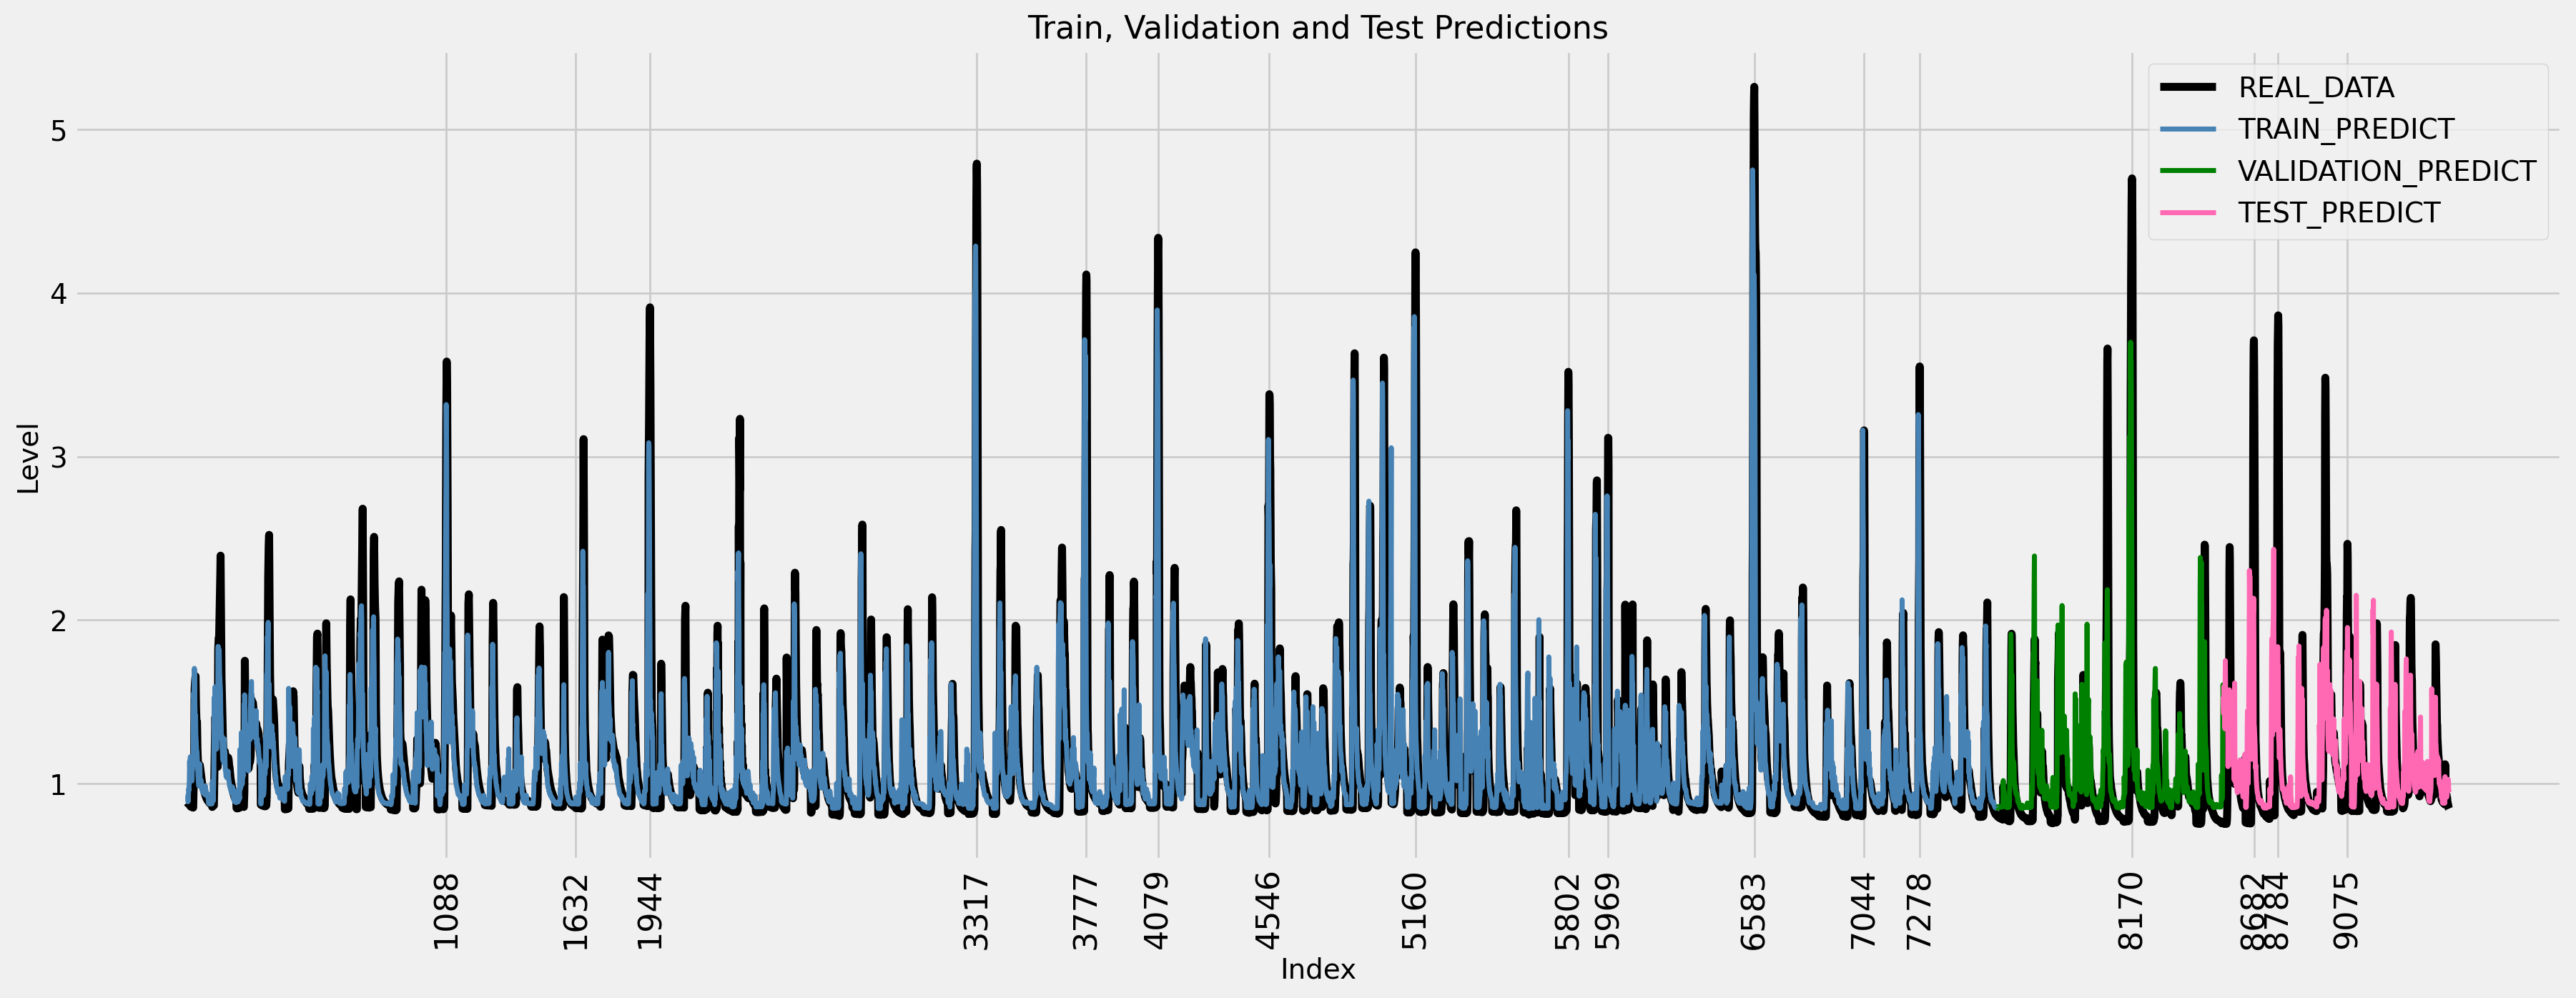

In [43]:
plt.figure(figsize=(20,7), dpi=200)
plt.plot(data_all.index.values, data_all['Level_corr'], color = 'black')
plt.plot(data_train.index.values, data_train['MW_Train'], lw=2.5, color = 'steelblue')
plt.plot(data_validation.index.values, data_validation['MW_Prediction'], lw=2.5, color = 'green')
plt.plot(data_test.index.values, data_test['MW_Test'], lw=2.5, color = 'hotpink')
#plt.xticks([8170, 8682, 8784, 9075], rotation='vertical', size=16)
plt.xticks([1088, 1632, 1944, 3317, 3777, 4079, 4546, 5160, 5802, 5969, 6583, 7044, 7278, 8170, 8682, 8784, 9075], rotation='vertical', size=16) #Flood days
plt.title('Train, Validation and Test Predictions', size=16)
plt.xlabel('Index', size=14)
plt.ylabel('Level', size=14)
plt.legend(['REAL_DATA', 'TRAIN_PREDICT', 'VALIDATION_PREDICT', 'TEST_PREDICT'])
plt.show()

Only Test Predictions

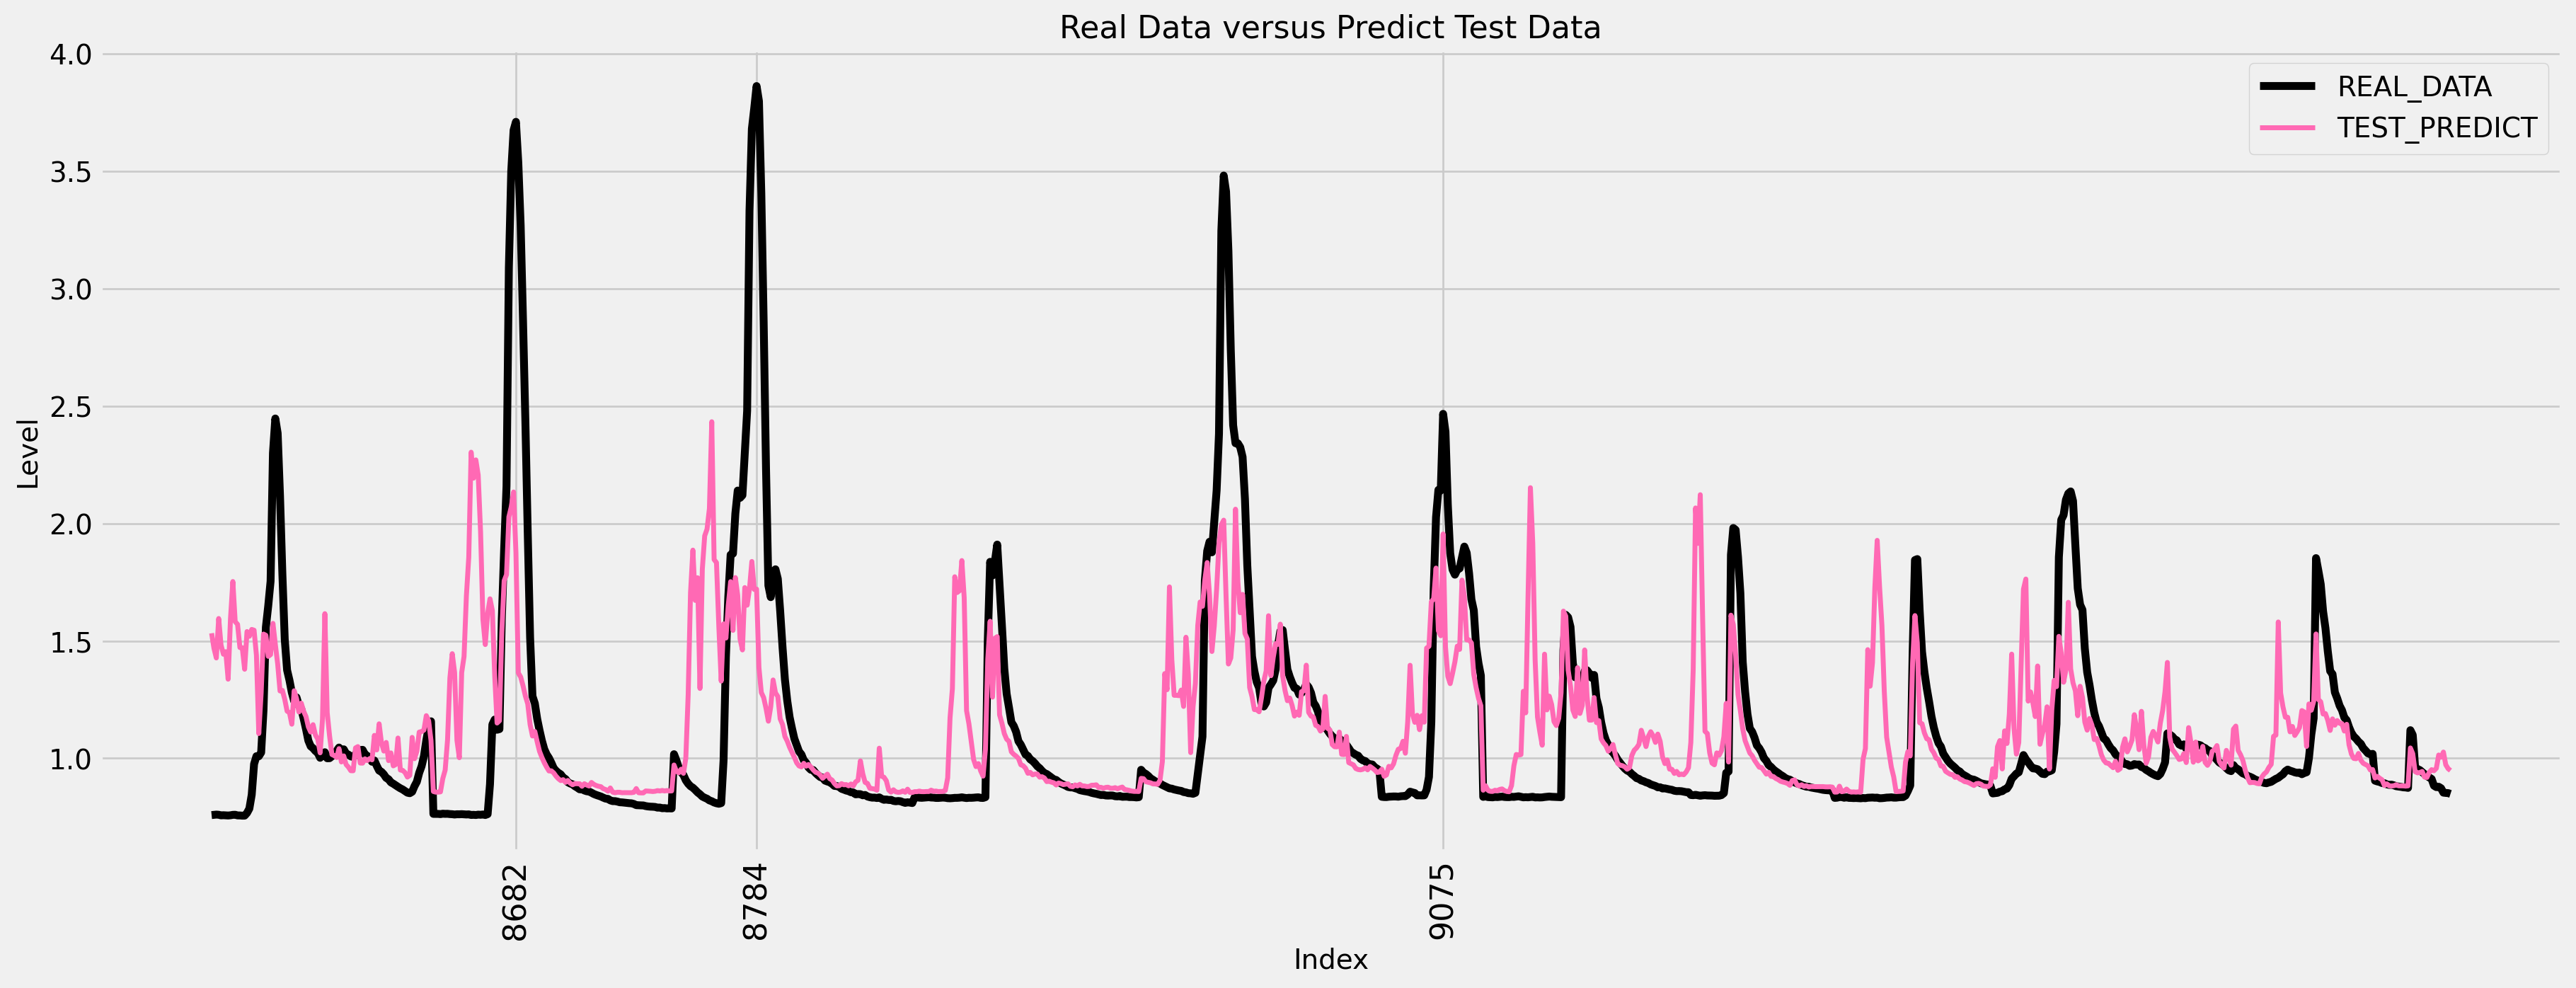

In [44]:
plt.figure(figsize=(20,7), dpi=200)
plt.plot(data_test.index.values, data_test['Level_corr'], color = 'black')
plt.plot(data_test.index.values, data_test['MW_Test'], lw=2.5, color = 'hotpink')
plt.xticks([8682, 8784, 9075], rotation='vertical', size=16)
plt.title('Real Data versus Predict Test Data', size=16)
plt.xlabel('Index', size=14)
plt.ylabel('Level', size=14)
plt.legend(['REAL_DATA', 'TEST_PREDICT'])
plt.show()